In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge', 'train.csv', 'train.csv'))

In [5]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\r\nWhy the edits made under my use...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\r\nMore\r\nI can't make any real suggestions...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [9]:
MAX_FEATURES = 200000

In [10]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES,
                              output_sequence_length = 1800,
                              output_mode = 'int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [14]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [16]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))

In [17]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [19]:
history = model.fit(train, epochs=5, validation_data=val)

Epoch 1/5
6981/6981 [==============================] - 5488s 786ms/step - loss: 0.0587 - val_loss: 0.0461
Epoch 2/5
6981/6981 [==============================] - 5624s 806ms/step - loss: 0.0455 - val_loss: 0.0423
Epoch 3/5
6981/6981 [==============================] - 5421s 777ms/step - loss: 0.0411 - val_loss: 0.0379
Epoch 4/5
6981/6981 [==============================] - 5555s 796ms/step - loss: 0.0366 - val_loss: 0.0321
Epoch 5/5
6981/6981 [==============================] - 5574s 798ms/step - loss: 0.0332 - val_loss: 0.0295


In [20]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

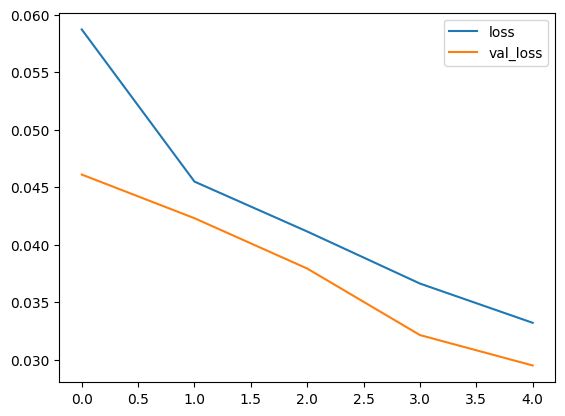

In [22]:
plt.figure(figsize = (8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [23]:
batch = test.as_numpy_iterator().next()

In [24]:
input_text = vectorizer('You asian motherfucker. I will kill you')

In [25]:
model.predict(np.expand_dims(input_text, 0))

array([[0.9998292 , 0.68435323, 0.9902111 , 0.20693986, 0.9439601 ,
        0.44815546]], dtype=float32)

In [26]:
model.save('toxic_comments.h5')

In [27]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [29]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

In [30]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8541762828826904, Recall:0.8120201826095581, Accuracy:0.5101123452186584


In [32]:
modeael = tf.keras.models.load_model('toxic_comments.h5')

In [40]:
input_str = vectorizer('I hate you. I\'m coming for you')

In [41]:
res = modeael.predict(np.expand_dims(input_str,0))

In [42]:
res

array([[0.7705947 , 0.00244811, 0.05300827, 0.03890601, 0.24083139,
        0.05729579]], dtype=float32)